<a href="https://colab.research.google.com/github/Guillem96/activity-recognition/blob/master/notebooks/Dense%20Trajectories%20Annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf taxi
!curl -O ftp://ftp.ira.uka.de/pub/vid-text/image_sequences/taxi/taxi.zip
!unzip -q taxi.zip
!rm taxi.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1454k  100 1454k    0     0  1415k      0  0:00:01  0:00:01 --:--:-- 1416k


In [ ]:
from pathlib import Path

import cv2 as cv
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

In [ ]:
taxis_fnames = sorted(list(Path('taxi').iterdir()))
print(f'Number of frames: {len(taxis_fnames)}')

Number of frames: 41


## Tracking point between 2 images


In [ ]:
rand_idx = np.random.randint(len(taxis_fnames) - 3, size=(1,)).item()

taxi1 = Image.open(taxis_fnames[rand_idx])
taxi2 = Image.open(taxis_fnames[rand_idx + 3])

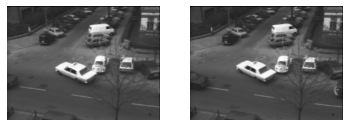

In [ ]:
plt.subplot(121)
plt.imshow(taxi1, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(taxi2, cmap='gray')
plt.axis('off');

In [ ]:
flow = cv.calcOpticalFlowFarneback(np.array(taxi1), 
                                   np.array(taxi2), 
                                   None, 0.5, 3, 15, 3, 5, 1.2, 0)

Feature points are sampled on a grid spaced by W pixels and tracked in each scale separately. Experimentally, we observed that a sampling step size of
$W = 5$ is dense enough to give good results.

In [ ]:
W = 5
p_x, p_y = np.arange(0, 256, W), np.arange(190, -1, -W)

$ P_{t + 1} = (x_{t + 1}, y_{t+1}) = (x_{t}, y_{t}) + (M * w)$

In [ ]:
r_p_y = p_y.reshape(-1, 1).repeat(p_x.shape, -1).reshape(-11, p_x.shape[0], 1)
r_p_x = p_x.reshape(1, -1, 1).repeat(p_y.shape[0], 0)
pt = np.concatenate([r_p_y, r_p_x], -1).reshape(-1, 2)
pt_1 = pt + np.take(cv.medianBlur(flow, step), sampled_points)

We plot samples of trajectories

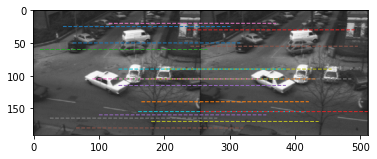

In [ ]:
rand_samples = np.random.randint(0, high=pt.shape[0], size=(20,))
plt.imshow(np.concatenate([np.array(taxi1), np.array(taxi2)], axis=1), 
           cmap='gray')
for point1, point2 in zip(pt[rand_samples], pt_1[rand_samples]):
    plt.plot([point1[1], point2[1] + 256], 
             [point1[0], point2[0]],
             '--', linewidth=1)

## Working with a whole video

In [ ]:
L = 15 #@param {"type": "slider", "min": 3, "max": 20 }

In [ ]:
def display_video(images):
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(images[0], cmap='gray')
    plt.close()

    def init():
        im.set_data(images[0])

    def animate(i):
        im.set_data(images[i])
        return im

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=len(images), interval=50)
    display(HTML(anim.to_html5_video()))

rand_idx = np.random.randint(0, high=len(taxis_fnames) - L, size=(1,)).item()
images = [Image.open(o) for o in taxis_fnames[rand_idx: rand_idx + L]]
display_video(images)

Sample the initial points to track

In [ ]:
p_x, p_y = np.arange(0, 256, W), np.arange(190, -1, -W)